In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mpl_lego as mplego

from functools import partial
from pyprojroot import here
from scipy.stats import mannwhitneyu, f_oneway
from mpl_lego.labels import bold_text
from mpl_lego.labels import add_significance_label

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
df1 = pd.read_csv(here('data/aita_processed_gpt_run_1.csv'))
df2 = pd.read_csv(here('data/aita_processed_gpt_run_2.csv'))
df3 = pd.read_csv(here('data/aita_processed_gpt_run_3.csv'))

In [4]:
comments = pd.read_csv(here('data/aita_all_comments_labeled.csv'))

In [5]:
df_base = df1.rename({'gpt_label': 'gpt_label_1', 'gpt_reason': 'gpt_reason_1'}, axis=1).drop('gpt_dilemma', axis=1)

In [6]:
df_base['gpt_label_2'] = df2['gpt_label']
df_base['gpt_reason_2'] = df2['gpt_reason']
df_base['gpt_label_3'] = df3['gpt_label']
df_base['gpt_reason_3'] = df3['gpt_reason']

In [9]:
df_base['gpt_nta_agreement'] = (df_base[['gpt_label_1', 'gpt_label_2', 'gpt_label_3']] == 'NTA').mean(axis=1)
df_base['gpt_yta_agreement'] = (df_base[['gpt_label_1', 'gpt_label_2', 'gpt_label_3']] == 'YTA').mean(axis=1)
df_base['gpt_esh_agreement'] = (df_base[['gpt_label_1', 'gpt_label_2', 'gpt_label_3']] == 'ESH').mean(axis=1)
df_base['gpt_nah_agreement'] = (df_base[['gpt_label_1', 'gpt_label_2', 'gpt_label_3']] == 'NAH').mean(axis=1)

In [10]:
comments_judgement = comments[comments['comment_label'] != 'NONE']

In [21]:
comments_nta_agreement = comments_judgement\
    .groupby('id')\
    .apply(
        lambda x: (x['comment_label'] == 'NTA').mean())\
    .to_frame()\
    .reset_index()\
    .rename({0: 'comments_nta_agreement'}, axis=1)

In [22]:
comments_yta_agreement = comments_judgement\
    .groupby('id')\
    .apply(
        lambda x: (x['comment_label'] == 'YTA').mean())\
    .to_frame()\
    .reset_index()\
    .rename({0: 'comments_yta_agreement'}, axis=1)

In [23]:
comments_esh_agreement = comments_judgement\
    .groupby('id')\
    .apply(
        lambda x: (x['comment_label'] == 'ESH').mean())\
    .to_frame()\
    .reset_index()\
    .rename({0: 'comments_esh_agreement'}, axis=1)

In [24]:
comments_nah_agreement = comments_judgement\
    .groupby('id')\
    .apply(
        lambda x: (x['comment_label'] == 'NAH').mean())\
    .to_frame()\
    .reset_index()\
    .rename({0: 'comments_nah_agreement'}, axis=1)

In [38]:
df_full.columns

Index(['submission_id', 'title', 'selftext', 'created_utc', 'permalink',
       'score', 'flair_text', 'top_comment', 'true_label', 'gpt_label_1',
       'gpt_reason_1', 'gpt_label_2', 'gpt_reason_2', 'gpt_label_3',
       'gpt_reason_3', 'gpt_nta_agreement', 'gpt_yta_agreement',
       'gpt_esh_agreement', 'gpt_nah_agreement', 'id_x',
       'comments_nta_agreement', 'id_y', 'comments_yta_agreement', 'id_x',
       'comments_esh_agreement', 'id_y', 'comments_nah_agreement'],
      dtype='object')

In [43]:
df_full = df_base.merge(
    right=comments_nta_agreement.set_index('id'),
    left_on='submission_id',
    right_index=True).merge(
    right=comments_yta_agreement.set_index('id'),
    left_on='submission_id',
    right_index=True).merge(
    right=comments_esh_agreement.set_index('id'),
    left_on='submission_id',
    right_index=True).merge(
    right=comments_nah_agreement.set_index('id'),
    left_on='submission_id',
    right_index=True)    

In [46]:
df_full.to_csv('aita_final_no_mfd.csv', index=False)

In [27]:
nta_groups = [df_full[df_full['gpt_nta_agreement'] == prop]['comments_nta_agreement'].values
              for prop in [0, 1./3, 2./3, 1]]
yta_groups = [df_full[df_full['gpt_yta_agreement'] == prop]['comments_yta_agreement'].values
              for prop in [0, 1./3, 2./3, 1]]
nah_groups = [df_full[df_full['gpt_nah_agreement'] == prop]['comments_nah_agreement'].values
              for prop in [0, 1./3, 2./3, 1]]
esh_groups = [df_full[df_full['gpt_esh_agreement'] == prop]['comments_esh_agreement'].values
              for prop in [0, 1./3, 2./3, 1]]

<Axes: xlabel='\\textbf{Number of GPT Runs Assigning NTA}', ylabel='\\textbf{Fraction of Comments}\n\\textbf{Assigning NTA}'>

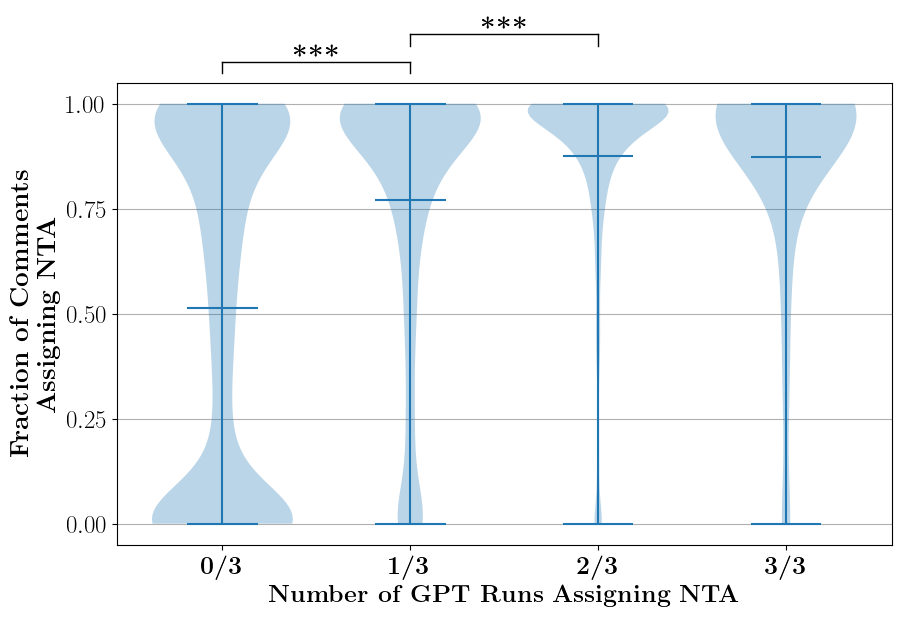

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.violinplot(showmeans=True,
              widths=0.25,
              dataset=nta_groups,
              positions=[0, 1./3, 2./3, 1])
ax.set_xticks([0, 1./3, 2./3, 1])
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax.set_xticklabels(bold_text(['0/3', '1/3', '2/3', '3/3']))
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_xlabel(bold_text('Number of GPT Runs Assigning NTA'), fontsize=18)
ax.set_ylabel(bold_text('Fraction of Comments\nAssigning NTA'), fontsize=19)

add_significance_label(ax,
                       bounds=[0, 1./3,],
                       label=bold_text('***'),
                       spacing=0.02,
                       width=0.025)
add_significance_label(ax,
                       bounds=[1./3, 2./3,],
                       label=bold_text('***'),
                       spacing=0.08,
                       width=0.025)

<Axes: xlabel='\\textbf{Number of GPT Runs Assigning YTA}', ylabel='\\textbf{Fraction of Comments}\n\\textbf{Assigning YTA}'>

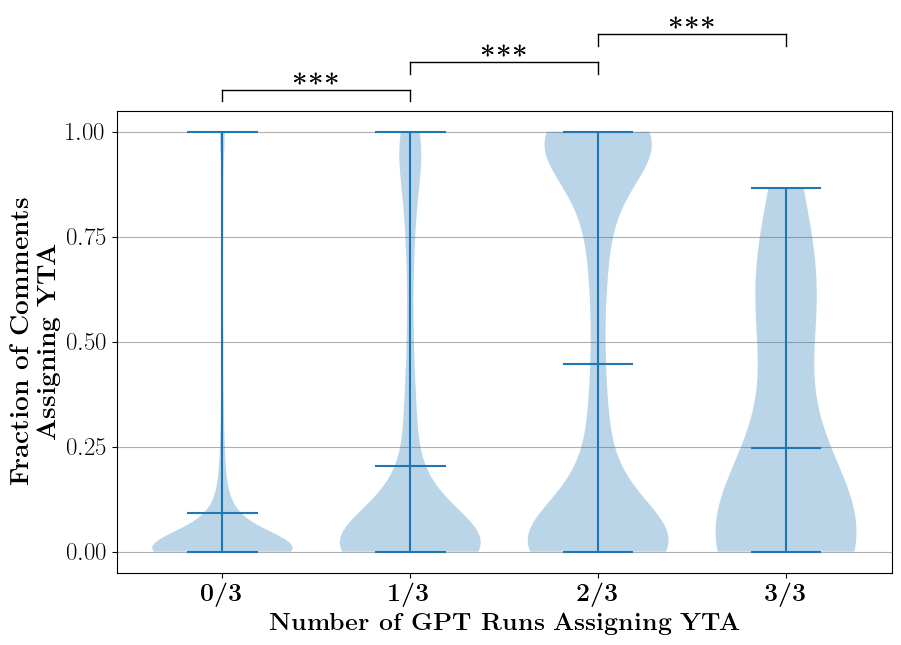

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.violinplot(showmeans=True,
              widths=0.25,
              dataset=yta_groups,
              positions=[0, 1./3, 2./3, 1])
ax.set_xticks([0, 1./3, 2./3, 1])
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax.set_xticklabels(bold_text(['0/3', '1/3', '2/3', '3/3']))
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_xlabel(bold_text('Number of GPT Runs Assigning YTA'), fontsize=18)
ax.set_ylabel(bold_text('Fraction of Comments\nAssigning YTA'), fontsize=19)

add_significance_label(ax,
                       bounds=[0, 1./3,],
                       label=bold_text('***'),
                       spacing=0.02,
                       width=0.025)
add_significance_label(ax,
                       bounds=[1./3, 2./3,],
                       label=bold_text('***'),
                       spacing=0.08,
                       width=0.025)
add_significance_label(ax,
                       bounds=[2./3, 3./3,],
                       label=bold_text('***'),
                       spacing=0.14,
                       width=0.025)

(0.0, 0.25)

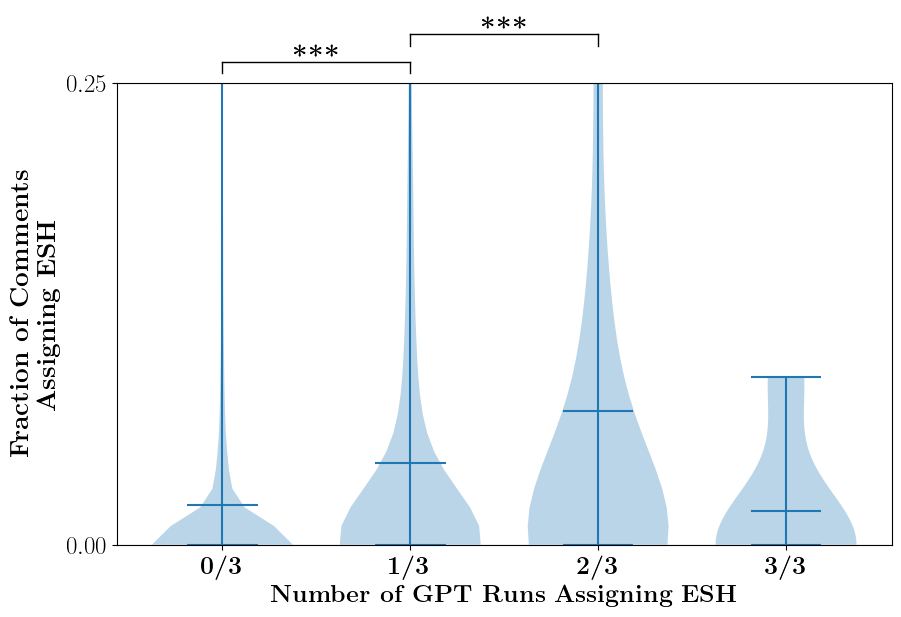

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.violinplot(showmeans=True,
              widths=0.25,
              dataset=esh_groups,
              positions=[0, 1./3, 2./3, 1])
ax.set_xticks([0, 1./3, 2./3, 1])
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax.set_xticklabels(bold_text(['0/3', '1/3', '2/3', '3/3']))
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_xlabel(bold_text('Number of GPT Runs Assigning ESH'), fontsize=18)
ax.set_ylabel(bold_text('Fraction of Comments\nAssigning ESH'), fontsize=19)

add_significance_label(ax,
                       bounds=[0, 1./3,],
                       label=bold_text('***'),
                       spacing=0.02,
                       width=0.025)
add_significance_label(ax,
                       bounds=[1./3, 2./3,],
                       label=bold_text('***'),
                       spacing=0.08,
                       width=0.025)

ax.set_ylim([0, 0.25])

<Axes: xlabel='\\textbf{Number of GPT Runs Assigning NAH}', ylabel='\\textbf{Fraction of Comments}\n\\textbf{Assigning NAH}'>

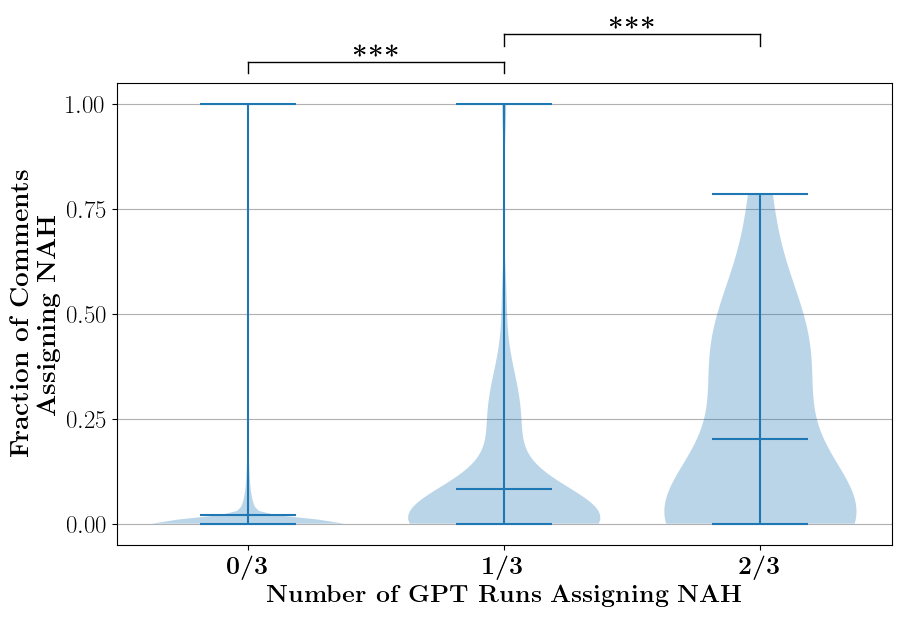

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.violinplot(showmeans=True,
              widths=0.25,
              dataset=nah_groups[:3],
              positions=[0, 1./3, 2./3])
ax.set_xticks([0, 1./3, 2./3, 1])
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax.set_xticklabels(bold_text(['0/3', '1/3', '2/3', '3/3']))
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.tick_params(labelsize=18)
ax.set_xlabel(bold_text('Number of GPT Runs Assigning NAH'), fontsize=18)
ax.set_ylabel(bold_text('Fraction of Comments\nAssigning NAH'), fontsize=19)

add_significance_label(ax,
                       bounds=[0, 1./3,],
                       label=bold_text('***'),
                       spacing=0.02,
                       width=0.025)
add_significance_label(ax,
                       bounds=[1./3, 2./3,],
                       label=bold_text('***'),
                       spacing=0.08,
                       width=0.025)

# ax.set_ylim([0, 0.25])